### Importing Libraries

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
!pip install keras_vggface
from keras_vggface.vggface import VGGFace

Using TensorFlow backend.


In [2]:
os.listdir('../input/humain/dataset')

['age', 'vgg_face_weights.h5', 'ethnicity', 'gender', 'emotion']

In [3]:
def assign_label(img,label):
    return label

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

### **Importing Pre-trained Model VGG Face for Transfer Learning**

In [5]:
base_model=VGGFace(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

weights_path='../input/humain/dataset/vgg_face_weights.h5' # 16 to 13 layers
base_model.load_weights(weights_path,by_name='True') 

## Gender Model

There will be 4 seperate models trained to predict age, gender, ethnicity and emotion.

Training Approach : Transfer learning on a pre-trained vggface convolutional neural network.

In [6]:
X=[]
Z=[]
IMG_SIZE=150
GENDER_MALE_DIR='../input/humain/dataset/gender/G_Male'
GENDER_FEMALE_DIR='../input/humain/dataset/gender/G_Female'

make_train_data('Male',GENDER_MALE_DIR)
make_train_data('Female',GENDER_FEMALE_DIR)

100%|██████████| 112/112 [00:00<00:00, 366.50it/s]


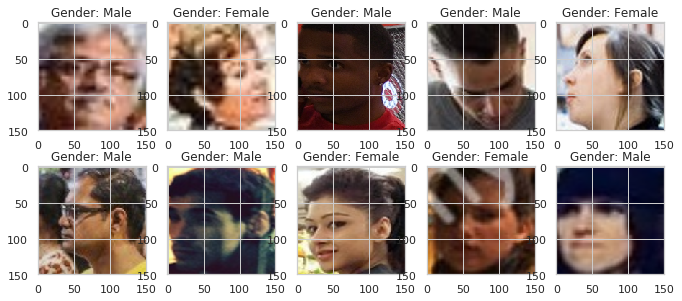

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title('Gender: '+Z[l])
        ax[i,j].set_aspect('equal')

In [8]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [9]:
gendermodel=Sequential()
gendermodel.add(base_model)
gendermodel.add(Dropout(0.4))
gendermodel.add(Dense(256,activation='relu'))
gendermodel.add(Dropout(0.4))
gendermodel.add(Dense(2,activation='softmax'))

### **Data Augmentation **

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Model Architechture

In [11]:
epochs=200
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

base_model.trainable=True # setting the VGG model to be trainable.
gendermodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_vgg16 (Model)        (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 14,846,530
Trainable params: 14,846,530
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [12]:
gendermodel.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

History = gendermodel.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

gendermodel.save('../working/gendermodel.h5')

Epoch 1/200
1/1 [==============================] - 66s 66s/step - loss: 0.6857 - acc: 0.6172 - val_loss: 0.6962 - val_acc: 0.4717
Epoch 2/200
1/1 [==============================] - 19s 19s/step - loss: 0.6853 - acc: 0.5667 - val_loss: 0.6960 - val_acc: 0.4340
Epoch 3/200
1/1 [==============================] - 60s 60s/step - loss: 0.6832 - acc: 0.5781 - val_loss: 0.6958 - val_acc: 0.4528
Epoch 4/200
1/1 [==============================] - 19s 19s/step - loss: 0.6853 - acc: 0.5000 - val_loss: 0.6956 - val_acc: 0.4717
Epoch 5/200
1/1 [==============================] - 60s 60s/step - loss: 0.6801 - acc: 0.5781 - val_loss: 0.6954 - val_acc: 0.4717
Epoch 6/200
1/1 [==============================] - 19s 19s/step - loss: 0.6726 - acc: 0.5667 - val_loss: 0.6955 - val_acc: 0.4340
Epoch 7/200
1/1 [==============================] - 60s 60s/step - loss: 0.6775 - acc: 0.5547 - val_loss: 0.6957 - val_acc: 0.4717
Epoch 8/200
1/1 [==============================] - 19s 19s/step - loss: 0.6645 - acc: 0.70

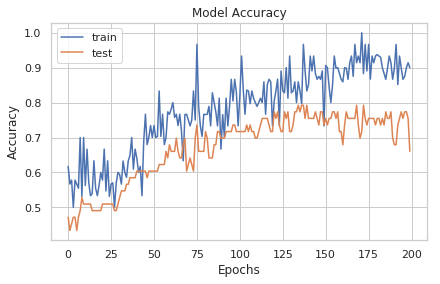

In [13]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

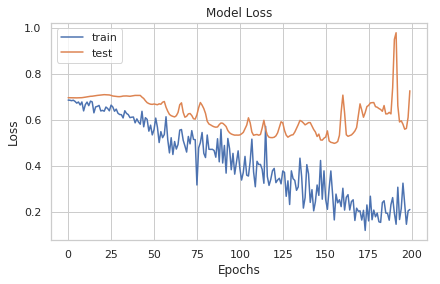

In [14]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()